# Change these flags to train a specific model
## Modifikationen
- Ausgabe der Images und Masken für Skript
- Convertieren der Masken zum Vergleich nach Binär, da nur Hintergrund (0) und Drüsen (1) relevant.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/BA_SemanticSegmentation_JonasHeinke/___P3-A_UNET-RESNET_NODE-PL-Segmenation_QU/

/content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte


In [ ]:
ls

Codeoptimierung_Hinweise.py
___Datasets/
___P3-A_UNET-RESNET_NODE-PL-Segmenation_QU/
___P3_neural-odes-segmentation-master_QU/
___P4-A_UNET-PL_Segmentation_CRAG/
___P4_neural-odes-segmentation-master_CRAG/
___P5-A_Eigenes_Projekt_Segmentation_subdivide_CRAG/
___P5_Eigenes_Projekt_Segmentation_CRAG/
___P5_Eigenes_Projekt_Segmentation_CRAG_____VORGAENGER/
___P7_Eigenes_Projekt_Segmentation_QU/


In [ ]:
cd ___P3-A_UNET-RESNET_NODE-PL-Segmenation_QU

/content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte/___P3-A_UNET-RESNET_NODE-PL-Segmenation_QU


In [ ]:
ls

'(3-1)_images_masks_listset_[75, 55, 5].png'
'(3-1)_images_masks_Objekte_[75, 55, 5].png'
'(3-1)_protokoll.txt'
 augmentations.py
 best_border_resnet_model.pt
 best_border_resnet_paper.pt
 best_border_unet_model.pt
 best_border_unet_paper.pt
 best_border_unode_paper.pt
 dataloader.py
 inference_utils.py
 LICENSE
 __MACOSX/
 metrics.py
 models.py
 models.py.gdoc
 model_utils.py
 MODULE/
'P3-A_01_train_models (352x512_epoch600) (202107-03)_Add(Klassenbezug, Visualisierung).ipynb'
'protokoll_prognose(352, 512).txt'
'protokoll_prognose(512, 768).txt'
 protokoll_prognose.txt
 __pycache__/
 README.md
'Test_Image_Maske_Prognose[14, 53, 51].png'
 train_utils.py
'Warwick QU Dataset (Released 2016_07_08)'/
 warwick_qu_dataset_released_2016_07_08.zip
 warwick_qu_dataset_released_2016_07_08.zip.1
 warwick_qu_dataset_released_2016_07_08.zip.2


In [ ]:
TRAIN_RESNET = True
TRAIN_UNODE = False
TRAIN_UNET = False

def get_title():
    if TRAIN_UNODE: return 'U-NODE'
    elif TRAIN_RESNET: return 'RESNET'
    elif TRAIN_UNET: return 'UNET'

In [ ]:
!pip install git+https://github.com/rtqichen/torchdiffeq

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-5_d__hkv
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-5_d__hkv


---

In [ ]:
import os
import glob
import random

import torch
import torch.utils.data

import PIL
import skimage.measure
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook

%matplotlib inline
from models import ConvODEUNet, ConvResUNet, ODEBlock, Unet
from dataloader import GLaSDataLoader
from train_utils import plot_losses

from IPython.display import clear_output

## Konstanten, Parameter
- jh: Zur einfacheren Parametrierung

In [ ]:
SHAPE_IMG=(3,352, 512)
SHAPE_MASK=(352, 512)
#SHAPE_IMG=(3,512, 768)
#SHAPE_MASK=(512, 768)

EP=600               # Epochen
LR=0.0001             # Lernrate
BL=5                 # Bloecke

# Commands to download the dataset

In [ ]:
if not os.path.exists('Warwick QU Dataset (Released 2016_07_08)'):
    !wget https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
    !unzip warwick_qu_dataset_released_2016_07_08.zip     

## Define datasets

In [ ]:
torch.manual_seed(0)

val_set_idx = torch.LongTensor(10).random_(0, 85)
train_set_idx = torch.arange(0, 85)

overlapping = (train_set_idx[..., None] == val_set_idx).any(-1)
train_set_idx = torch.masked_select(train_set_idx, ~overlapping)

In [ ]:
trainset = GLaSDataLoader(SHAPE_MASK, dataset_repeat=1, images=train_set_idx)
valset = GLaSDataLoader(SHAPE_MASK, dataset_repeat=1, images=val_set_idx, validation=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=2)

# Plotting train data

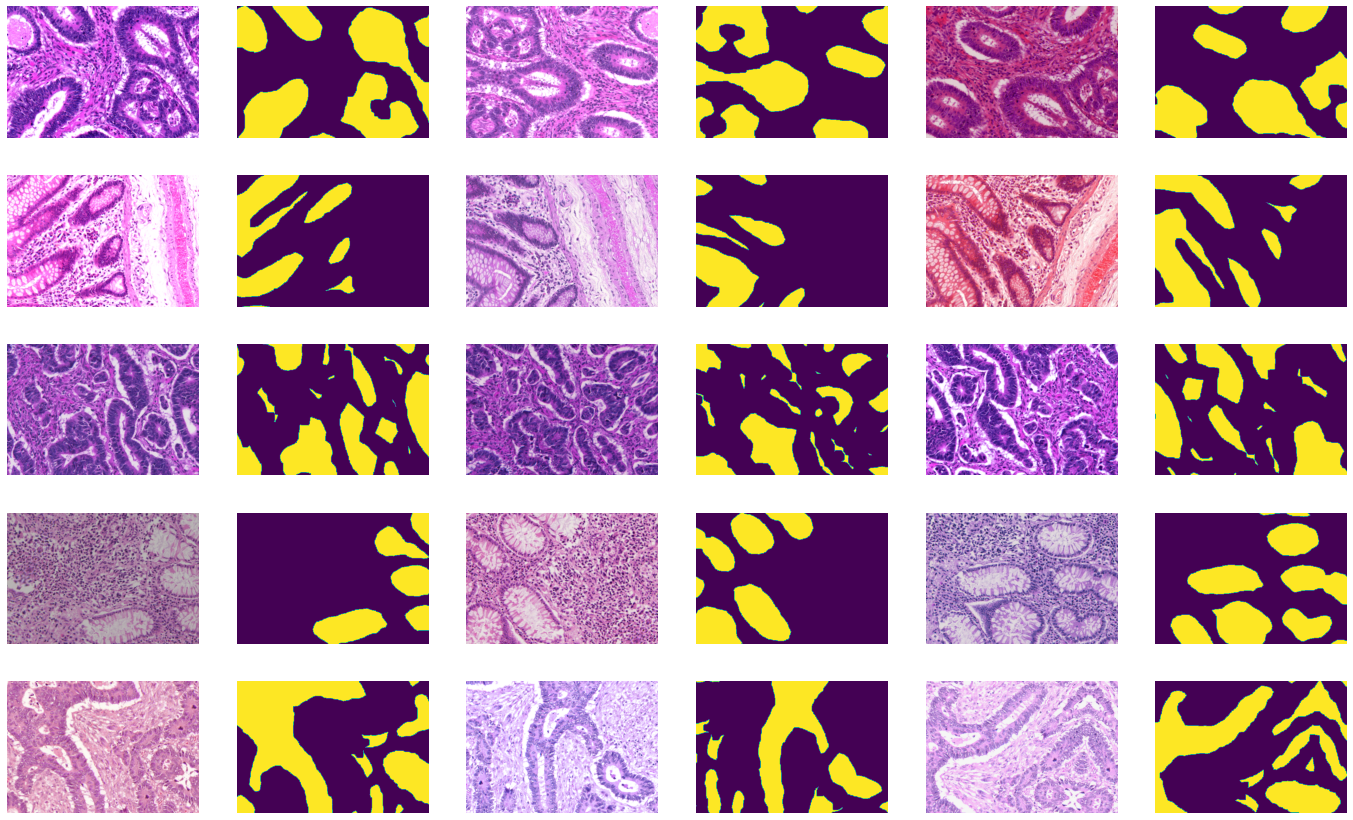

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(24, 15))

for y in range(5):
    for x in range(3):
        sample = trainset[y]
        ax[y, x * 2].imshow(sample[0].numpy().transpose(1,2,0))
        ax[y, x * 2 + 1].imshow(sample[1][0])
        ax[y, x * 2].axis('off')
        ax[y, x * 2 + 1].axis('off')

plt.show();

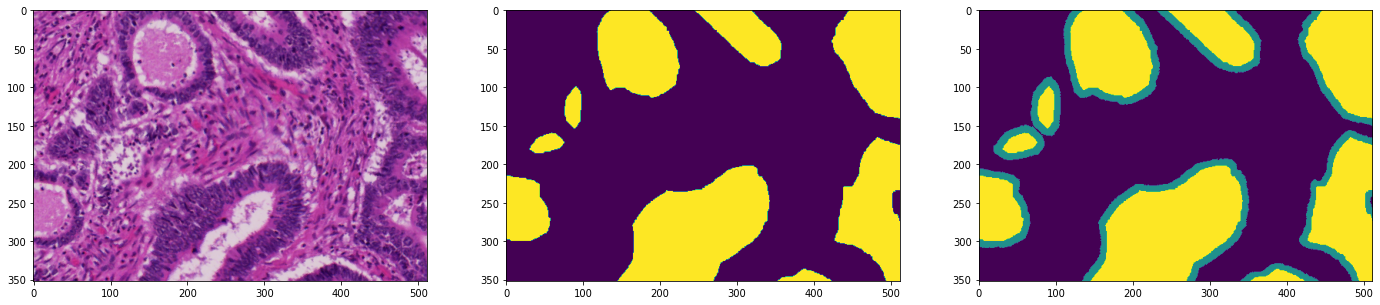

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 15))

sample = trainset[0]
ax[1].imshow(sample[1][0].numpy())
ax[2].imshow(sample[1].sum(dim=0))
ax[0].imshow(sample[0].numpy().transpose(1,2,0))

# Plotting validation data

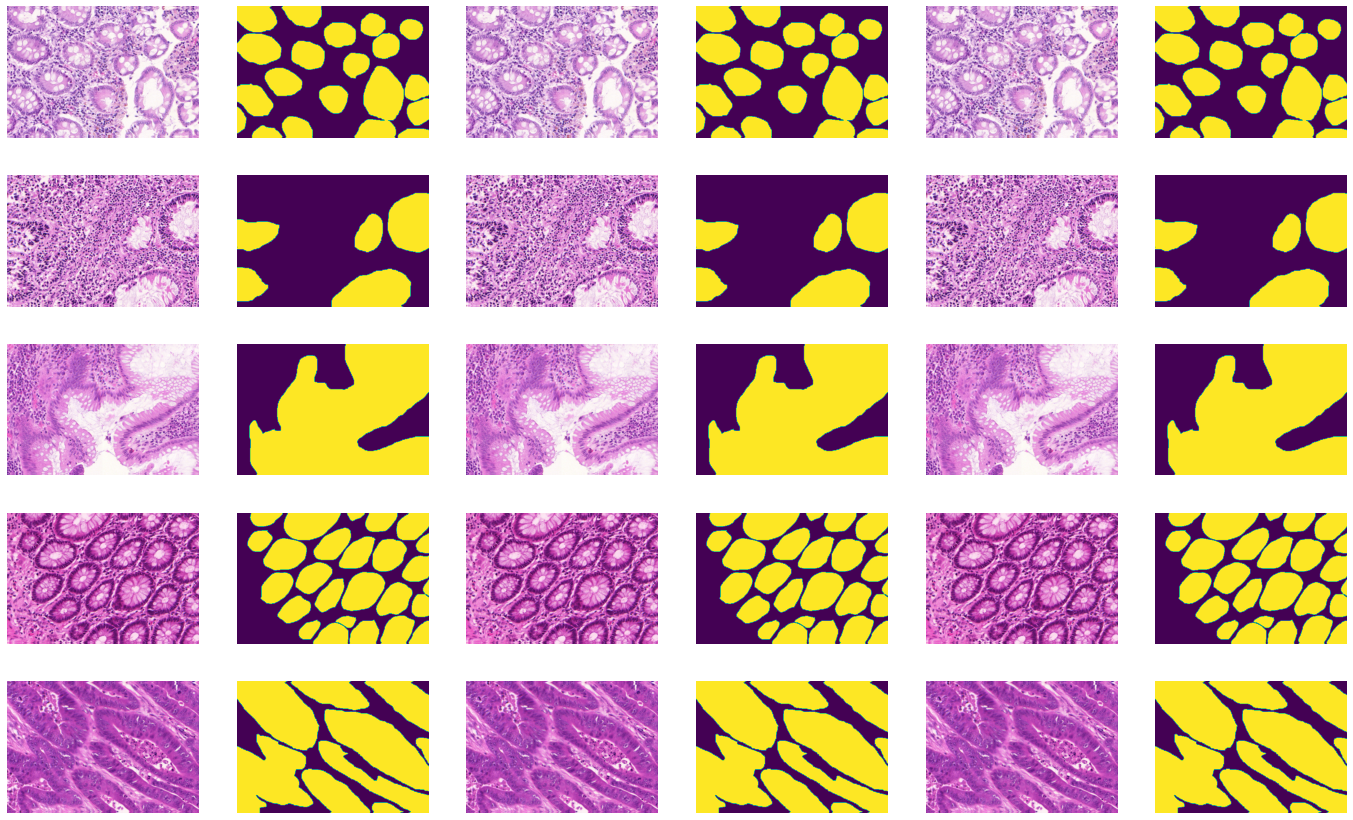

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(24, 15))

for y in range(5):
    for x in range(3):
        sample = valset[y]
        ax[y, x * 2].imshow(sample[0].numpy().transpose(1,2,0))
        ax[y, x * 2 + 1].imshow(sample[1][1])
        ax[y, x * 2].axis('off')
        ax[y, x * 2 + 1].axis('off')

plt.show(); 

# Define network

In [ ]:
devicename='cuda'
device = torch.device(devicename)

if TRAIN_UNODE:
    net = ConvODEUNet(num_filters=16, output_dim=2, time_dependent=True, 
                      non_linearity='lrelu', adjoint=True, tol=1e-3)
    net.to(device)

In [ ]:
if TRAIN_RESNET:
    net = ConvResUNet(num_filters=16, output_dim=2, non_linearity='lrelu')
    net.to(device)

In [ ]:
if TRAIN_UNET:
    net = Unet(depth=BL, num_filters=64, output_dim=2).cuda()
    # net = Unet(depth=5, num_filters=16, output_dim=2).cuda() # --> schlechter
    net.to(device)

## Modell zeigen

In [ ]:
print(get_title())
from torchsummary import summary
#-# summary = summary(net, (3,352, 512), device='cuda')
summary = summary(net, SHAPE_IMG, device=devicename)

RESNET
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 352, 512]              64
         LeakyReLU-2         [-1, 16, 352, 512]               0
    InstanceNorm2d-3         [-1, 16, 352, 512]               0
            Conv2d-4         [-1, 16, 352, 512]           2,320
         LeakyReLU-5         [-1, 16, 352, 512]               0
    InstanceNorm2d-6         [-1, 16, 352, 512]               0
            Conv2d-7         [-1, 16, 352, 512]           2,320
         LeakyReLU-8         [-1, 16, 352, 512]               0
       ConvResFunc-9         [-1, 16, 352, 512]               0
           Conv2d-10         [-1, 32, 352, 512]             544
        LeakyReLU-11         [-1, 32, 352, 512]               0
   InstanceNorm2d-12         [-1, 32, 176, 256]               0
           Conv2d-13         [-1, 32, 176, 256]           9,248
        LeakyReLU-14         [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


## Verarbeitung

---

In [ ]:
for m in net.modules():
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(net)

2074098

# Train model

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
val_criterion = torch.nn.BCEWithLogitsLoss()

if TRAIN_UNET:
    cross_entropy = torch.nn.BCEWithLogitsLoss()

    def criterion(conf, labels):
        out_shape = conf.shape[2:4]
        label_shape = labels.shape[2:4]

        w = (label_shape[1] - out_shape[1]) // 2
        h = (label_shape[1] - out_shape[1]) // 2
        dh, dw = out_shape[0:2]

        conf_loss_ce = cross_entropy(conf, labels[:, :, h:h+dh, w:w+dw])

        return conf_loss_ce

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
losses = []
val_losses = []
nfe = [[],[],[],[],[],[],[],[],[]] if TRAIN_UNODE else None

In [ ]:
accumulate_batch = 8  # mini-batch size by gradient accumulation
accumulated = 0

if TRAIN_RESNET: filename = 'best_border_resnet_model.pt'
elif TRAIN_UNODE: filename = 'best_border_unode_model.pt'
elif TRAIN_UNET: filename = 'best_border_unet_model.pt'

def run(lr=1e-3, epochs=100):
    accumulated = 0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    for epoch in range(epochs):
        
        # training loop with gradient accumulation
        running_loss = 0.0
        optimizer.zero_grad()
        for data in tqdm(trainloader):
            inputs, labels = data[0].cuda(), data[1].cuda()
            outputs = net(inputs)
            loss = criterion(outputs, labels) / accumulate_batch
            loss.backward()
            accumulated += 1
            if accumulated == accumulate_batch:
                optimizer.step()
                optimizer.zero_grad()
                accumulated = 0

            running_loss += loss.item() * accumulate_batch

        losses.append(running_loss / len(trainloader))
        
        # validation loop
        with torch.no_grad():
            running_loss = 0.0
            for data in valloader:
                inputs, labels = data[0].cuda(), data[1].cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            val_losses.append(running_loss / len(valloader))
            if np.argmin(val_losses) == len(val_losses) - 1 and loss < 0.4:
                torch.save(net, filename)
                
            clear_output(wait=True)
            plot_losses(inputs, outputs, losses, val_losses, get_title(), nfe, net=net)

In [ ]:
import datetime
protokoll_train = open('(3-1)_protokoll.txt', mode='w')
protokoll_train.write(f'--- Projekt 3-1 --- Shape: {SHAPE_IMG}, {SHAPE_IMG}, Epochen: {EP}, Lernrate: {LR}  ---\n')

93

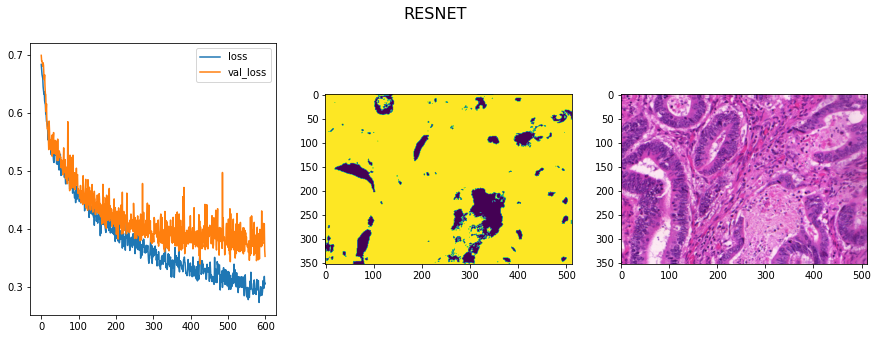

In [ ]:
if TRAIN_UNODE or TRAIN_RESNET: lr = LR  # 1e-3 
else: lr = LR # 1e-4
protokoll_train.write(f'Training start: {datetime.datetime.now()}\n')
# Training starten
run(lr, EP - len(losses))
protokoll_train.write(f'Training end:   {datetime.datetime.now()}\n')
protokoll_train.close()

# Calculate results

In [ ]:
# filename='best_border_unet_model.pt'
# load best model
net = torch.load(filename)

In [ ]:
with torch.no_grad():
    running_loss = 0.0
    for data in tqdm(valloader):
        inputs, labels = data[0].cuda(), data[1].cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    print("Check validation loss:", running_loss / len(valloader))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
100%|██████████| 10/10 [00:00<00:00, 13.29it/s]

Check validation loss: 0.3397101774811745


# Visualize results on validation set

In [ ]:
from inference_utils import inference_image, postprocess

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


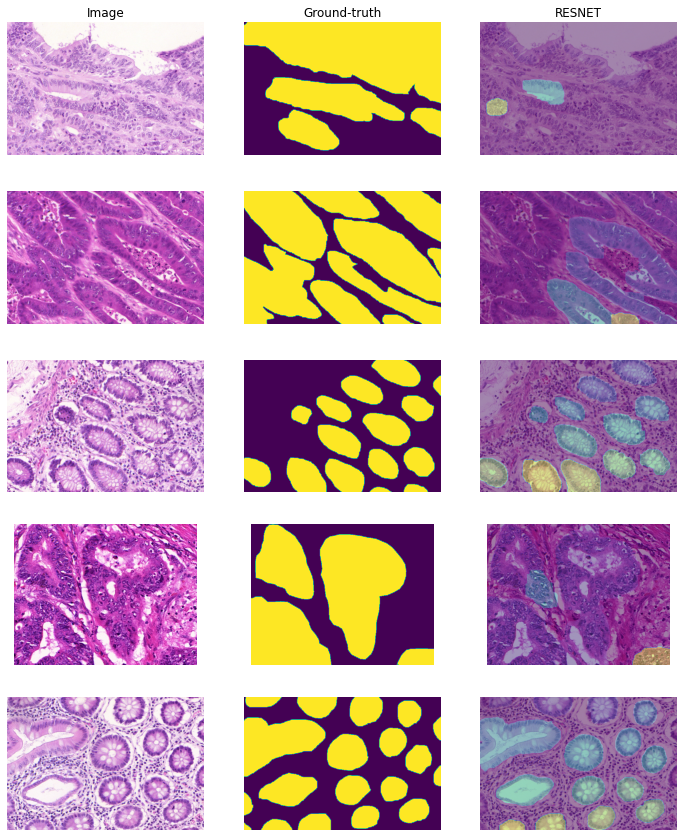

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(4*3,3*5))

ax[0, 0].set_title('Image')
ax[0, 1].set_title('Ground-truth')
ax[0, 2].set_title(get_title())

for col in range(3):
    for row in range(5):
        index = val_set_idx[row]
        image = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)/train_{index}.bmp')
        gt = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)/train_{index}_anno.bmp')
        
        with torch.no_grad():
            result, input_image = inference_image(net, image, shouldpad=TRAIN_UNET)
            result = postprocess(result, gt)
        if col == 0:
            ax[row, col].imshow(image)
        elif col == 1:
            ax[row, col].imshow(np.array(gt) > 0)
        else:
            ax[row, col].imshow(image)
            ax[row, col].imshow(result, alpha=0.5)
                
        ax[row, col].set_axis_off()

plt.show(); 

# Calculate metrics on test set

In [ ]:
from metrics import ObjectDice, ObjectHausdorff, F1score

In [ ]:
TEST_RESNET = True
TEST_UNODE = False
TEST_UNET = False

In [ ]:
if TEST_UNODE: net = torch.load('best_border_unode_model.pt')
elif TEST_RESNET: net = torch.load('best_border_resnet_model.pt')
elif TEST_UNET: net = torch.load('best_border_unet_model.pt')

In [ ]:
#from MODULE.JH.transforms import TwoClasses2 #???
from MODULE.JH.img_array_transform import ArrayTransform as TRANSFORM
# Instanzen von Klassen ggf.
transform=TRANSFORM() # Klassenistanz

### Identnummernbezogene/Objektbezogene Bewertung
- [ Id=0 - Hintergrund, Durchnummerierung der Drüsen je Maske von Id=1, 2 , 3 , ..., n

In [ ]:
protokolldatei = open(f'protokoll_prognose{SHAPE_MASK}.txt','w')

protokolldatei.write('\nObjektbezogenen Kennzahlen:\n')
# Tabellenkopf
print_string=(f' idx | dice_img  | f1_img    | hausdorff_img ')
protokolldatei.write(print_string+'\n')

46

In [ ]:
dice, hausdorff, f1, dice_full = 0, 0, 0, 0

if TEST_UNODE: folder = 'results_unode'
elif TEST_UNET: folder = 'results_unet'
elif TEST_RESNET: folder = 'results_resnet'
    
images = []
for index in np.arange(1, 81):
    if index < 61: images.append(f'testA_{index}_anno.bmp')
    else: images.append(f'testB_{index - 60}_anno.bmp')
print(f' idx | dice_img  | f1_img    | hausdorff_img ') # Tabellenkopf        
for i, fname in tqdm_notebook(enumerate(images), total=80):
    gt = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)/' + fname)
    image = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)/' + fname.replace('_anno', ''))
    
    result, resized = inference_image(net, image, shouldpad=TEST_UNET)
    result = postprocess(result, gt)

    gt = skimage.measure.label(np.array(gt))
   
    
    f1_img = F1score(result, gt)
    hausdorff_img = ObjectHausdorff(result, gt)
    dice_img = ObjectDice(result, gt)
    
    f1 += f1_img
    hausdorff += hausdorff_img
    dice += dice_img

    if i == 59:        
        diceA = dice 
        hausdorffA = hausdorff 
        f1A = f1

    #print(i, f1_img, hausdorff_img, dice_img)
    print_string=(f' {i:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} ')
    print(print_string)
    # --- Protokoll ---
    protokolldatei.write(print_string+'\n')


diceB = dice - diceA
hausdorffB = hausdorff - hausdorffA
f1B = f1 - f1A

print('ObjectDice:', dice / 80, 'A', diceA / 60, 'B', diceB / 20)
print('Hausdorff:', hausdorff / 80, 'A', hausdorffA / 60, 'B', hausdorffB / 20)
print('F1:', f1 / 80, 'A', f1A / 60, 'B', f1B / 20)





 idx | dice_img  | f1_img    | hausdorff_img 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   0 |     0.493 |     0.082 |       446.038 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   1 |     0.738 |     0.500 |       260.398 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   2 |     0.788 |     0.267 |       149.753 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   3 |     0.696 |     0.300 |       526.716 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   4 |     0.733 |     0.438 |       489.481 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   5 |     0.650 |     0.444 |       543.419 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   6 |     0.652 |     0.333 |       323.110 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   7 |     0.765 |     0.207 |       463.929 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   8 |     0.739 |     0.357 |       477.342 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   9 |     0.632 |     0.421 |       534.267 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  10 |     0.523 |     0.500 |       467.515 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  11 |     0.564 |     0.174 |       428.194 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  12 |     0.544 |     0.125 |       533.315 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  13 |     0.629 |     0.205 |       445.733 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  14 |     0.648 |     0.148 |       469.110 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  15 |     0.651 |     0.273 |       367.616 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  16 |     0.529 |     0.129 |       367.202 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  17 |     0.757 |     0.481 |       468.922 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  18 |     0.798 |     0.548 |       537.877 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  19 |     0.847 |     0.385 |       476.519 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  20 |     0.726 |     0.400 |       456.911 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  21 |     0.618 |     0.296 |       498.646 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  22 |     0.511 |     0.095 |       529.622 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  23 |     0.663 |     0.233 |       465.353 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  24 |     0.828 |     0.524 |       439.727 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  25 |     0.879 |     0.545 |       211.876 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  26 |     0.701 |     0.485 |       512.281 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  27 |     0.757 |     0.548 |       550.765 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  28 |     0.854 |     0.500 |       463.976 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  29 |     0.895 |     0.593 |       410.440 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  30 |     0.703 |     0.471 |       416.440 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  31 |     0.553 |     0.294 |       489.553 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  32 |     0.694 |     0.378 |       471.874 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  33 |     0.669 |     0.207 |       486.946 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  34 |     0.924 |     0.857 |       401.311 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  35 |     0.832 |     0.757 |       491.176 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  36 |     0.496 |     0.138 |       294.133 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  37 |     0.977 |     1.000 |        17.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  38 |     0.811 |     0.333 |       264.265 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  39 |     0.819 |     0.667 |       432.473 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  40 |     0.665 |     0.333 |       530.810 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  41 |     0.679 |     0.222 |       384.080 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  42 |     0.846 |     0.473 |       376.942 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  43 |     0.599 |     0.150 |       269.686 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  44 |     0.724 |     0.381 |       301.410 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  45 |     0.773 |     0.524 |       505.913 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  46 |     0.718 |     0.353 |       312.431 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  47 |     0.855 |     0.280 |       451.665 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  48 |     0.680 |     0.522 |       337.039 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  49 |     0.886 |     0.769 |       363.608 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  50 |     0.912 |     0.600 |       311.972 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  51 |     0.919 |     0.643 |       405.203 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  52 |     0.872 |     0.476 |       289.828 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  53 |     0.664 |     0.369 |       421.461 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  54 |     0.811 |     0.385 |       256.544 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  55 |     0.781 |     0.237 |       412.571 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  56 |     0.293 |     0.034 |       473.114 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  57 |     0.831 |     0.778 |       429.757 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  58 |     0.506 |     0.045 |       365.017 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  59 |     0.852 |     0.621 |       355.352 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  60 |     0.173 |     0.000 |       394.688 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  61 |     0.542 |     0.118 |       389.542 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  62 |     0.858 |     0.188 |       358.368 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  63 |     0.857 |     0.364 |       189.310 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  64 |     0.564 |     0.148 |       415.547 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  65 |     0.211 |     0.000 |       361.940 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  66 |     0.797 |     0.364 |       280.965 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  67 |     0.801 |     0.222 |       310.662 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  68 |     0.453 |     0.207 |       300.761 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  69 |     0.472 |     0.231 |       330.869 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  70 |     0.953 |     0.421 |       388.828 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  71 |     0.438 |     0.095 |       363.299 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  72 |     0.802 |     0.341 |       403.795 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  73 |     0.065 |     0.000 |       540.434 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  74 |     0.298 |     0.000 |       405.865 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  75 |     0.322 |     0.000 |       337.581 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  76 |     0.591 |     0.053 |       340.088 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  77 |     0.769 |     0.462 |       428.878 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  78 |     0.520 |     0.154 |       448.830 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  79 |     0.839 |     0.074 |       194.960 
ObjectDice: 0.6809756142371478 A 0.7192461284787649 B 0.5661640715122968
Hausdorff: 397.7604444983702 A 410.5937879701225 B 359.26041408311323
F1: 0.34091918037054 A 0.397220568013766 B 0.17201501744086195


In [ ]:
protokolldatei.write('\n Mittelwerte, Objektbezogenen Kennzahlen (OB):\n')
protokolldatei.write(f'ObjectDice: {dice / 80}, A: {diceA / 60}, B: {diceB / 20}\n')
protokolldatei.write(f'Hausdorff: {hausdorff / 80}, A: {hausdorffA / 60}, B: {hausdorffB / 20}\n')
protokolldatei.write(f'F1: {f1 / 80}, A: {f1A / 60}, B: {f1B / 20}\n')


67

### klassenbezogene Bewertung 
- [0 - Hintergrund, 1- Drüsen]

In [ ]:
protokolldatei.write('\nKlassenbezogenen Kennzahlen (KB):\n')
# Tabellenkopf
print_string=(f' idx | dice_img  | f1_img    | hausdorff_img ')
protokolldatei.write(print_string+'\n')

46

In [ ]:
dice, hausdorff, f1, dice_full = 0, 0, 0, 0

if TEST_UNODE: folder = 'results_unode'
elif TEST_UNET: folder = 'results_unet'
elif TEST_RESNET: folder = 'results_resnet'
    
images = []
for index in np.arange(1, 81):
    if index < 61: images.append(f'testA_{index}_anno.bmp')
    else: images.append(f'testB_{index - 60}_anno.bmp')
print(f' idx | dice_img  | f1_img    | hausdorff_img ') # Tabellenkopf           
for i, fname in tqdm_notebook(enumerate(images), total=80):
    gt = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)/' + fname)
    image = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)/' + fname.replace('_anno', ''))
    
    result, resized = inference_image(net, image, shouldpad=TEST_UNET)
    result = postprocess(result, gt)

    gt = skimage.measure.label(np.array(gt))
    
    # To Binaer, da nur Hintergund (0) und Drüsen (1) (JH)
    gt_kb= transform.twoClasses(gt)
    result_kb= transform.twoClasses(result)
    
    
    f1_img = F1score(result_kb, gt_kb)
    hausdorff_img = ObjectHausdorff(result_kb, gt_kb)
    dice_img = ObjectDice(result_kb, gt_kb)


    
    f1 += f1_img
    hausdorff += hausdorff_img
    dice += dice_img

    if i == 59:        
        diceA = dice 
        hausdorffA = hausdorff 
        f1A = f1

    #print(i, f1_img, hausdorff_img, dice_img)
    print_string=(f' {i:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} ')
    print(print_string)
    # --- Protokoll ---
    protokolldatei.write(print_string+'\n')

diceB = dice - diceA
hausdorffB = hausdorff - hausdorffA
f1B = f1 - f1A

print('ObjectDice:', dice / 80, 'A', diceA / 60, 'B', diceB / 20)
print('Hausdorff:', hausdorff / 80, 'A', hausdorffA / 60, 'B', hausdorffB / 20)
print('F1:', f1 / 80, 'A', f1A / 60, 'B', f1B / 20)




 idx | dice_img  | f1_img    | hausdorff_img 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   0 |     0.624 |     0.000 |       141.608 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   1 |     0.836 |     1.000 |       225.078 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   2 |     0.890 |     1.000 |        54.626 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   3 |     0.681 |     1.000 |       441.203 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   4 |     0.810 |     1.000 |       139.043 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   5 |     0.744 |     1.000 |       185.809 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   6 |     0.775 |     1.000 |       171.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   7 |     0.898 |     1.000 |        78.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   8 |     0.823 |     1.000 |       140.036 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


   9 |     0.725 |     1.000 |       280.672 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  10 |     0.336 |     0.000 |       280.835 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  11 |     0.828 |     1.000 |        94.895 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  12 |     0.838 |     1.000 |       107.201 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  13 |     0.677 |     1.000 |       192.520 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  14 |     0.563 |     0.000 |       147.840 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  15 |     0.796 |     1.000 |       118.929 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  16 |     0.704 |     1.000 |       147.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  17 |     0.780 |     1.000 |       108.079 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  18 |     0.827 |     1.000 |       111.879 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  19 |     0.876 |     1.000 |       102.303 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  20 |     0.827 |     1.000 |       125.718 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  21 |     0.795 |     1.000 |       165.759 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  22 |     0.851 |     1.000 |       151.822 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  23 |     0.825 |     1.000 |       112.330 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  24 |     0.840 |     1.000 |       109.037 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  25 |     0.937 |     1.000 |        35.341 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  26 |     0.724 |     1.000 |       132.439 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  27 |     0.842 |     1.000 |        84.172 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  28 |     0.888 |     1.000 |        71.113 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  29 |     0.934 |     1.000 |       112.294 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  30 |     0.899 |     1.000 |        70.711 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  31 |     0.690 |     1.000 |       181.813 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  32 |     0.852 |     1.000 |       104.403 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  33 |     0.855 |     1.000 |       139.291 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  34 |     0.952 |     1.000 |        64.761 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  35 |     0.891 |     1.000 |        92.655 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  36 |     0.725 |     1.000 |       355.028 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  37 |     0.977 |     1.000 |        17.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  38 |     0.852 |     1.000 |        98.234 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  39 |     0.844 |     1.000 |       226.013 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  40 |     0.744 |     1.000 |       125.936 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  41 |     0.836 |     1.000 |       122.332 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  42 |     0.870 |     1.000 |       101.356 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  43 |     0.816 |     1.000 |        76.538 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  44 |     0.864 |     1.000 |       144.257 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  45 |     0.843 |     1.000 |       108.259 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  46 |     0.866 |     1.000 |       132.231 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  47 |     0.898 |     1.000 |        86.533 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  48 |     0.775 |     1.000 |       158.751 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  49 |     0.901 |     1.000 |        98.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  50 |     0.916 |     1.000 |        39.115 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  51 |     0.933 |     1.000 |       109.604 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  52 |     0.876 |     1.000 |        41.049 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  53 |     0.776 |     1.000 |       185.011 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  54 |     0.809 |     1.000 |       260.465 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  55 |     0.893 |     1.000 |       138.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  56 |     0.674 |     1.000 |       149.251 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  57 |     0.880 |     1.000 |       131.244 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  58 |     0.681 |     1.000 |       216.301 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  59 |     0.870 |     1.000 |       110.494 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  60 |     0.376 |     0.000 |       281.017 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  61 |     0.860 |     1.000 |       140.014 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  62 |     0.921 |     1.000 |        85.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  63 |     0.857 |     1.000 |       203.039 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  64 |     0.793 |     1.000 |       294.109 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  65 |     0.434 |     0.000 |       329.837 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  66 |     0.861 |     1.000 |       132.575 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  67 |     0.882 |     1.000 |        90.907 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  68 |     0.671 |     1.000 |       160.910 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  69 |     0.742 |     1.000 |       107.703 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  70 |     0.967 |     1.000 |        61.033 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  71 |     0.686 |     1.000 |       282.733 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  72 |     0.879 |     1.000 |       159.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  73 |     0.370 |     0.000 |       538.078 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  74 |     0.499 |     0.000 |       169.614 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  75 |     0.692 |     1.000 |       152.227 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  76 |     0.677 |     1.000 |       222.733 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  77 |     0.923 |     1.000 |        54.000 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  78 |     0.752 |     1.000 |       156.984 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


  79 |     0.909 |     1.000 |       111.400 
ObjectDice: 0.7938590912264415 A 0.8126151950692578 B 0.7375907796979924
Hausdorff: 149.82663750714494 A 137.5536304288365 B 186.64565874207028
F1: 0.9125 A 0.95 B 0.8


In [ ]:
protokolldatei.write('\n Mittelwerte, klassenbezogene Kennzahlen (KB): \n')
protokolldatei.write(f'ObjectDice: {dice / 80}, A: {diceA / 60}, B: {diceB / 20} \n')
protokolldatei.write(f'Hausdorff: {hausdorff / 80}, A: {hausdorffA / 60}, B: {hausdorffB / 20} \n')
protokolldatei.write(f'F1: {f1 / 80}, A: {f1A / 60}, B: {f1B / 20}\n')

28

In [ ]:
protokolldatei.close()

## Visualisierung 1 mit Zwischendarstellung

In [ ]:
def showPrognose(result_prog):
    '''Zum Visualisieren des Prognoseergbnisses ohne Nachbearbeitung (ohne Postprozess)'''
    #print(result_1.shape)
    kanal=np.zeros((1,result_prog.shape[1], result_prog.shape[2]))
    result_prog=np.concatenate((result_prog, kanal))
    result_prog=result_prog.transpose((2,1,0))
    result_prog=np.rot90(result_prog,k=1)
    result_prog=np.flip(result_prog, 0)

    return result_prog

In [ ]:
images, gts, results_prog, results=[],[],[],[]
for idx in range(80):
    
    fnameimage= f'/testA_{idx+1}.bmp'
    fnamemask= f'/testA_{idx+1}_anno.bmp'
    if idx >= 60:
        fnameimage= f'/testB_{idx+1-60}.bmp'
        fnamemask= f'/testB_{idx+1-60}_anno.bmp'

    image = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)' + fnameimage)
    gt = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)' + fnamemask)
    with torch.no_grad():
        # Prognose
        result_prog, input_image = inference_image(net, image, shouldpad=TRAIN_UNET)
        # Nachbearbeitung
        result = postprocess(result_prog, gt)
    images.append(image)
    gts.append(gt)
    
    # Zum Visualisieren des Prognoseergbnisses ohne Nachbearbeitung 
    result_prog=showPrognose(result_prog)

    results_prog.append(result_prog)
    results.append(result)
print(len(images))   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


80


In [ ]:
from importlib import reload
import MODULE.JH.visualize
reload(MODULE.JH.visualize)

from MODULE.JH.visualize import Show as SHOW

show=SHOW(experiment='', figsize=(15,15), fontsize=16)

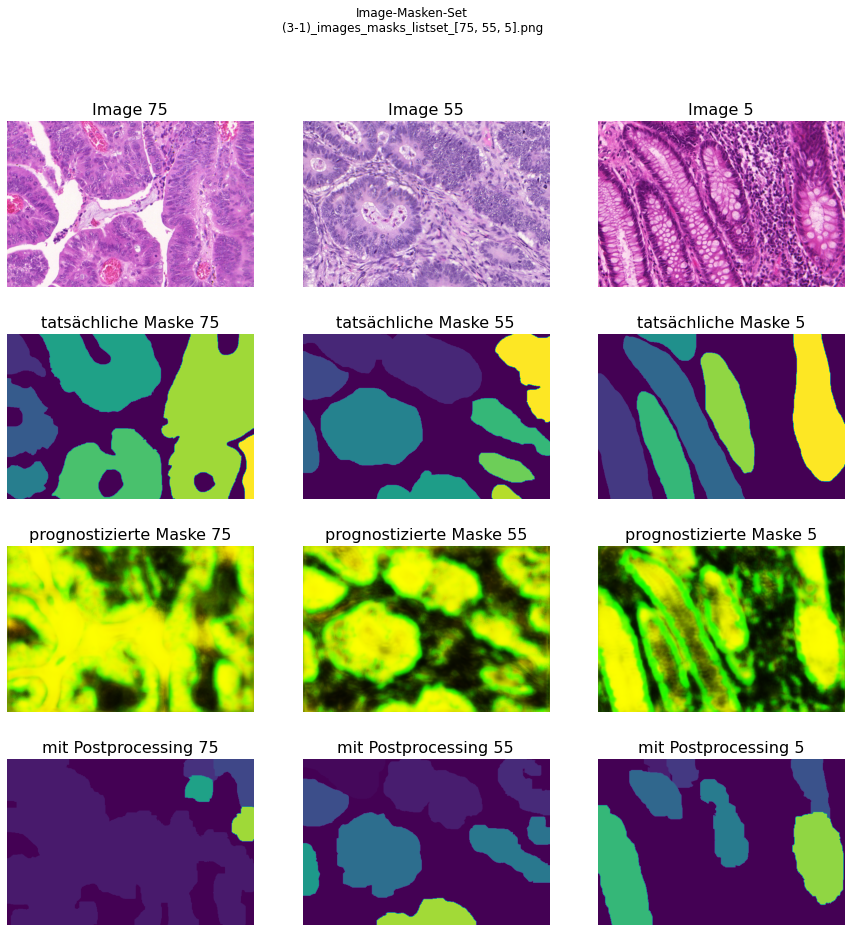

In [ ]:
idx_list=list([75,55,5])
path_set= f'(3-1)_images_masks_listset_{str(idx_list)}.png'

listset=list([images, gts, results_prog, results])
titles=list(['Image', 'tatsächliche Maske','prognostizierte Maske', 'mit Postprocessing'])

show.list_set(idx_list, listset,titles, path=path_set)

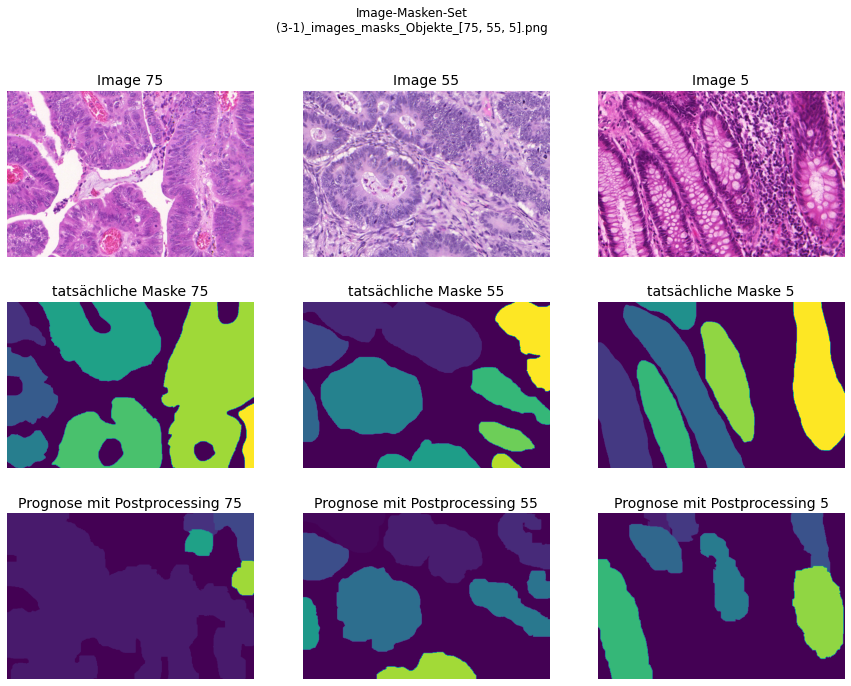

In [ ]:
show=SHOW(experiment='', figsize=(15,11), fontsize=14)
path_set= f'(3-1)_images_masks_Objekte_{str(idx_list)}.png'

listset=list([images, gts, results])
titles=list(['Image', 'tatsächliche Maske','Prognose mit Postprocessing'])

show.list_set(idx_list, listset,titles, path=path_set)

## Visualisierung 2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


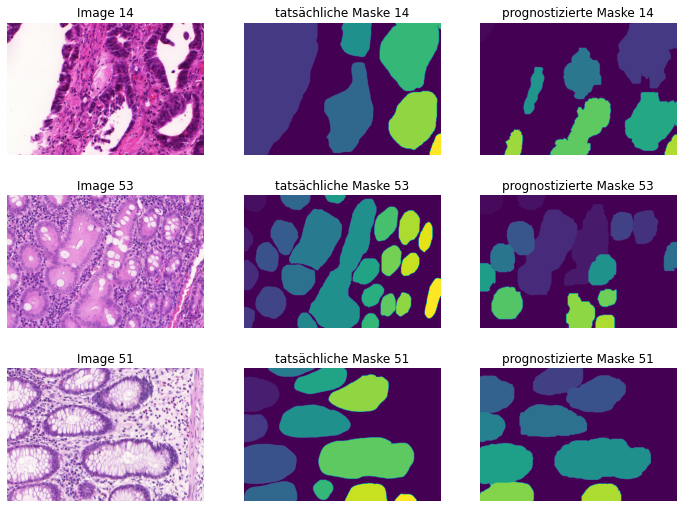

In [ ]:
# Ergänzung: Ausgabe von Images und Masken für das Skript (JH)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(4*3,3*3))
samples=[14, 53, 51]

for col in range(3):
    for row in range(3):
        #index = val_set_idx[samples[row]]
        ax[row, 0].set_title(f'Image {samples[row]}')
        ax[row, 1].set_title(f'tatsächliche Maske {samples[row]}')
        ax[row, 2].set_title(f'prognostizierte Maske {samples[row]}')
        
        index = samples[row]
        
        fnameimage= f'/testA_{index+1}.bmp'
        fnamemask= f'/testA_{index+1}_anno.bmp'
        if index >= 60:
            fnameimage= f'/testB_{index+1-60}.bmp'
            fnamemask= f'/testB_{index+1-60}_anno.bmp'
            
        
        image = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)' + fnameimage)
        gt = PIL.Image.open(f'Warwick QU Dataset (Released 2016_07_08)' + fnamemask)
        
        with torch.no_grad():
            result, input_image = inference_image(net, image, shouldpad=TRAIN_UNET)
            result = postprocess(result, gt)
        
        
        with torch.no_grad():
            result, input_image = inference_image(net, image, shouldpad=TRAIN_UNET)
            result = postprocess(result, gt)
        if col == 0:
            ax[row, col].imshow(image)
        elif col == 1:
            #ax[row, col].imshow(np.array(gt) > 0)
            ax[row, col].imshow(np.array(gt))
        else:
            ax[row, col].imshow(image)
            ax[row, col].imshow(result, alpha=1)
                
        ax[row, col].set_axis_off()

plt.savefig(f'Test_Image_Maske_Prognose{samples}.png', bbox_inches="tight")
plt.show(); 

In [ ]:
print('ENDE')

ENDE
